Final Deliverable

Revised Gridworld + Qlearning algo-Soham

In [ ]:
# For Colab ig we usually already have numpy, matplotlib, etc.
# If needed, uncomment:
#!pip install numpy matplotlib

#yeah its already there. Just need to import it. Usually all the commonly used files are available in nb.

In [ ]:
from __future__ import annotations
import numpy as np
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional

Coord = Tuple[int,int,int]

@dataclass
class GridSpec:
    H: int = 6; W: int = 6; D: int = 6
    p_intended: float = 0.8
    step_cost: float = -1.0
    gamma: float = 0.95
    goal: Coord = (5,5,5)
    pit:  Coord = (2,2,2)
    obstacle_ratio: float = 0.12
    start: Coord = (0,0,0)
    seed: Optional[int] = 12345

class Gridworld3D:
    ACTIONS = {
        0: np.array([+1,0,0]), 1: np.array([-1,0,0]),
        2: np.array([0,+1,0]), 3: np.array([0,-1,0]),
        4: np.array([0,0,+1]), 5: np.array([0,0,-1]),
    }
    def __init__(self, spec: GridSpec):
        self.spec = spec
        self.rng = np.random.default_rng(spec.seed)
        self.H,self.W,self.D = spec.H,spec.W,spec.D
        self.gamma = spec.gamma
        self.obstacles = self._generate_obstacles(spec.obstacle_ratio)
        for c in (spec.start, spec.goal, spec.pit):
            self.obstacles.discard(c)
        self.terminals: Dict[Coord,float] = {spec.goal:+50.0, spec.pit:-50.0}
        self._build_state_index()
        self.start = spec.start if spec.start in self.state2idx else self.idx2state[0]
        self._s = self.start

    @property
    def nS(self): return len(self.idx2state)
    @property
    def nA(self): return 6

    def reset(self):
        self._s = self.start
        return self.state2idx[self._s]

    def step(self, a:int):
        # absorbing guard
        if self._s in self.terminals:
            r = self.terminals[self._s]
            return self.state2idx[self._s], r, True, {}

        assert 0 <= a < 6
        p = self.spec.p_intended
        slips = self._perpendicular_actions(a)
        slip_p = (1-p)/4.0
        choices = np.array([a]+slips, dtype=int)
        probs   = np.array([p]+[slip_p]*4, dtype=float)
        chosen = int(self.rng.choice(choices, p=probs))
        s_next = self._attempt_move(self._s, chosen)

        if s_next in self.terminals:
            r = self.terminals[s_next]; done = True
        else:
            r = self.spec.step_cost; done = False
        self._s = s_next
        return self.state2idx[self._s], r, done, {}

    # helpers
    def _attempt_move(self, s:Coord, a:int)->Coord:
        nxt = tuple(np.array(s) + self.ACTIONS[a])
        return s if self._is_blocked(nxt) else nxt

    def _perpendicular_actions(self, a:int)->List[int]:
        axis = a // 2
        others = [ax for ax in (0,1,2) if ax != axis]
        res=[]
        for ax in others: res.extend([2*ax, 2*ax+1])
        return res

    def _is_blocked(self, s:Coord)->bool:
        x,y,z = s
        return (x<0 or x>=self.H or y<0 or y>=self.W or z<0 or z>=self.D or s in self.obstacles)

    def _build_state_index(self):
        self.state2idx={}; self.idx2state=[]
        for z in range(self.D):
            for y in range(self.W):
                for x in range(self.H):
                    s=(x,y,z)
                    if s in self.obstacles: continue
                    self.state2idx[s]=len(self.idx2state)
                    self.idx2state.append(s)

    def _generate_obstacles(self, ratio:float):
        total=self.H*self.W*self.D
        n_obs=int(round(total*ratio))
        cells=[(x,y,z) for z in range(self.D) for y in range(self.W) for x in range(self.H)]
        idx=self.rng.choice(len(cells), size=n_obs, replace=False)
        return {cells[i] for i in idx}

    # tiny helpers for debugging
    def coord_of(self, idx:int)->Coord: return self.idx2state[idx]
    def idx_of(self, coord:Coord)->int: return self.state2idx[coord]


In [ ]:
from dataclasses import dataclass, field
import matplotlib.pyplot as plt

@dataclass
class EpsilonSchedule:
    start: float = 1.0
    end: float = 0.05
    decay: float = 0.999
    def update(self, eps: float)->float:
        return max(self.end, eps*self.decay)

@dataclass
class QConfig:
    alpha: float = 0.2
    gamma: float = 0.95
    episodes: int = 5000
    max_steps_per_ep: int | None = None
    eps_schedule: EpsilonSchedule = field(default_factory=EpsilonSchedule)
    seed: int | None = 2024

class QLearningAgent:
    def __init__(self, env: Gridworld3D, cfg: QConfig):
        self.env=env; self.cfg=cfg
        self.rng=np.random.default_rng(cfg.seed)
        self.Q=np.zeros((env.nS, env.nA), dtype=float)
        vol=env.H*env.W*env.D
        self.max_steps = cfg.max_steps_per_ep or int(3*vol)

    def greedy_action(self, s:int)->int:
        row=self.Q[s]; m=row.max()
        candidates=np.flatnonzero(row==m)
        return int(self.rng.choice(candidates))
    def epsilon_greedy(self, s:int, eps:float)->int:
        return int(self.rng.integers(self.env.nA)) if self.rng.random()<eps else self.greedy_action(s)

    def train(self):
        alpha,gamma=self.cfg.alpha,self.cfg.gamma
        eps=self.cfg.eps_schedule.start
        returns=np.zeros(self.cfg.episodes, dtype=float)
        for ep in range(self.cfg.episodes):
            s=self.env.reset(); G=0.0; done=False; t=0
            while not done and t<self.max_steps:
                a=self.epsilon_greedy(s, eps)
                s2,r,done,_=self.env.step(a)
                best_next = 0.0 if done else np.max(self.Q[s2])
                td_target = r + gamma*best_next
                self.Q[s,a] += alpha*(td_target - self.Q[s,a])
                s=s2; G+=r; t+=1
            eps=self.cfg.eps_schedule.update(eps)
            returns[ep]=G
            if (ep+1)%500==0 or ep==0:
                print(f"[ep={ep+1}] return={G:.1f} eps={eps:.3f}")
        return returns

    def policy_matrix(self): return np.argmax(self.Q, axis=1)

def moving_average(x, k=50):
    if k<=1: return x
    c=np.cumsum(np.insert(x,0,0.0))
    out=(c[k:]-c[:-k])/k
    return np.concatenate([np.full(k-1, out[0]), out])

def evaluate_random_policy(env: Gridworld3D, episodes=100, seed=777):
    rng=np.random.default_rng(seed)
    vol=env.H*env.W*env.D; max_steps=int(3*vol)
    total=0.0
    for _ in range(episodes):
        s=env.reset(); done=False; t=0; G=0.0
        while not done and t<max_steps:
            a=int(rng.integers(env.nA))
            s,r,done,_=env.step(a)
            G+=r; t+=1
        total+=G
    return total/episodes


[ep=1] return=-648.0 eps=0.999
[ep=500] return=24.0 eps=0.606
[ep=1000] return=10.0 eps=0.368
[ep=1500] return=28.0 eps=0.223
[ep=2000] return=30.0 eps=0.135
[ep=2500] return=21.0 eps=0.082
[ep=3000] return=30.0 eps=0.050
[ep=3500] return=26.0 eps=0.050
[ep=4000] return=34.0 eps=0.050
[ep=4500] return=36.0 eps=0.050
[ep=5000] return=33.0 eps=0.050


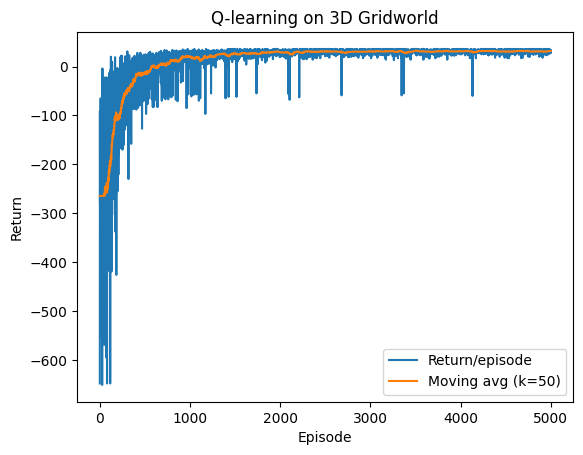

Greedy avg return: 32.07 | Random avg return: -270.87


<Figure size 640x480 with 0 Axes>

In [ ]:
# build env + agent
spec = GridSpec()  # default values per assignment
env = Gridworld3D(spec)
cfg = QConfig(gamma=spec.gamma, episodes=5000, alpha=0.2)
agent = QLearningAgent(env, cfg)

returns = agent.train()

# plot
plt.figure()
plt.plot(returns, label="Return/episode")
plt.plot(moving_average(returns, 50), label="Moving avg (k=50)")
plt.title("Q-learning on 3D Gridworld")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend(); plt.show()
plt.savefig("learning_curve.png", dpi=150, bbox_inches="tight")

# quick eval
# --- Evaluate greedy policy (no exploration) ---
def eval_greedy(agent, env, episodes=100):
    total = 0.0
    vol = env.H * env.W * env.D
    max_steps = int(3 * vol)
    for _ in range(episodes):
        s = env.reset()
        done = False
        t = 0
        G = 0.0
        while not done and t < max_steps:
            a = agent.greedy_action(s)
            s, r, done, _ = env.step(a)
            G += r
            t += 1
        total += G
    return total / episodes

g_avg = eval_greedy(agent, env, episodes=100)
r_avg = evaluate_random_policy(env, episodes=100)  # this was defined earlier
print(f"Greedy avg return: {g_avg:.2f} | Random avg return: {r_avg:.2f}")


HeatMap plotting

In [ ]:
# --- Value heatmaps + arrows (notebook version) ---
import numpy as np
import matplotlib.pyplot as plt

ARROW_2D = {0:(+1,0), 1:(-1,0), 2:(0,+1), 3:(0,-1), 4:(0,0), 5:(0,0)}

def values_from_Q(Q): return np.max(Q, axis=1)

def plot_slice_notebook(env, Q, z, title=""):
    V = values_from_Q(Q)
    H, W, D = env.H, env.W, env.D
    V2 = np.full((H,W), np.nan)
    A2 = np.full((H,W), -1, dtype=int)

    for s_idx, (x,y,zz) in enumerate(env.idx2state):
        if zz != z: continue
        V2[x,y] = V[s_idx]
        A2[x,y] = int(np.argmax(Q[s_idx]))

    U = np.zeros_like(V2); Vv = np.zeros_like(V2)
    for x in range(H):
        for y in range(W):
            a = A2[x,y]
            if a < 0: continue
            dx, dy = ARROW_2D[a]
            U[x,y] = dx; Vv[x,y] = dy

    X, Y = np.meshgrid(range(W), range(H))
    plt.figure()
    plt.imshow(np.flipud(V2.T), interpolation="nearest")
    mask = ~np.isnan(V2)
    xs = X[mask]; ys = Y[mask]
    us = U[mask]; vs = Vv[mask]
    plt.quiver(xs, H-1-ys, us, -vs, angles="xy", scale_units="xy", scale=1)
    plt.colorbar(label="V(s) = max_a Q(s,a)")
    plt.title(title or f"Value & policy (z={z})")
    plt.xlabel("y"); plt.ylabel("x"); plt.tight_layout()
    plt.show()


Day 4-5 CSV and plot generation

[ep=1] return=-648.0 eps=0.999
[ep=500] return=17.0 eps=0.606
[ep=1000] return=26.0 eps=0.368
[ep=1500] return=29.0 eps=0.223
[ep=2000] return=26.0 eps=0.135
[ep=2500] return=30.0 eps=0.082
[ep=3000] return=30.0 eps=0.050
[ep=3500] return=36.0 eps=0.050
[ep=4000] return=30.0 eps=0.050
[ep=4500] return=25.0 eps=0.050
[ep=5000] return=27.0 eps=0.050


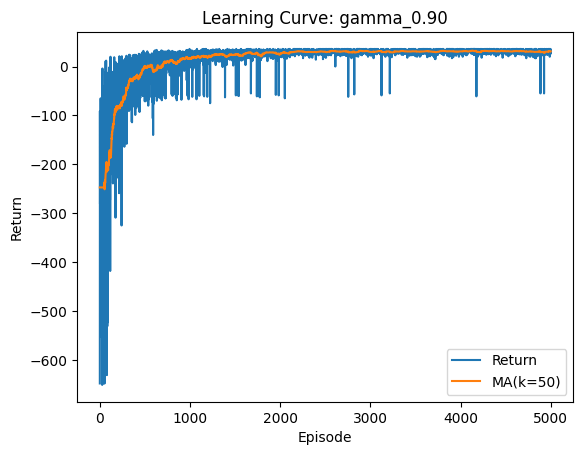

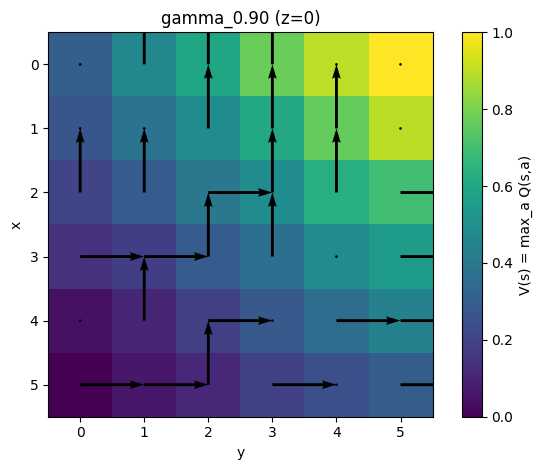

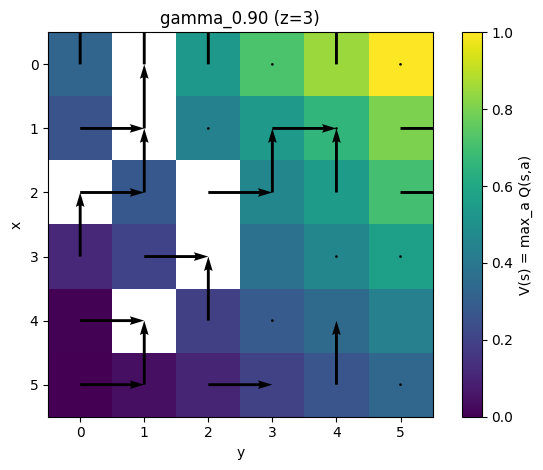

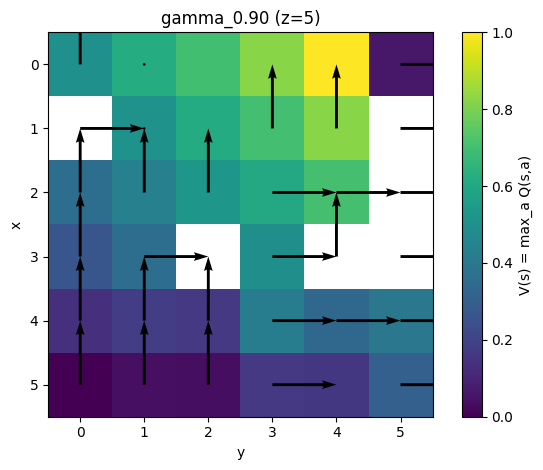

[ep=1] return=-648.0 eps=0.999
[ep=500] return=24.0 eps=0.606
[ep=1000] return=10.0 eps=0.368
[ep=1500] return=28.0 eps=0.223
[ep=2000] return=30.0 eps=0.135
[ep=2500] return=21.0 eps=0.082
[ep=3000] return=30.0 eps=0.050
[ep=3500] return=26.0 eps=0.050
[ep=4000] return=34.0 eps=0.050
[ep=4500] return=36.0 eps=0.050
[ep=5000] return=33.0 eps=0.050


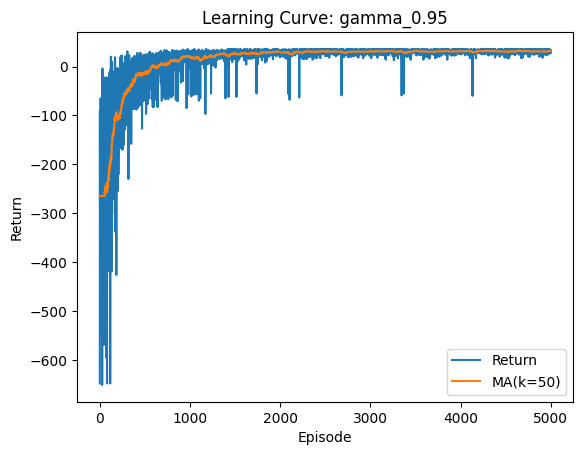

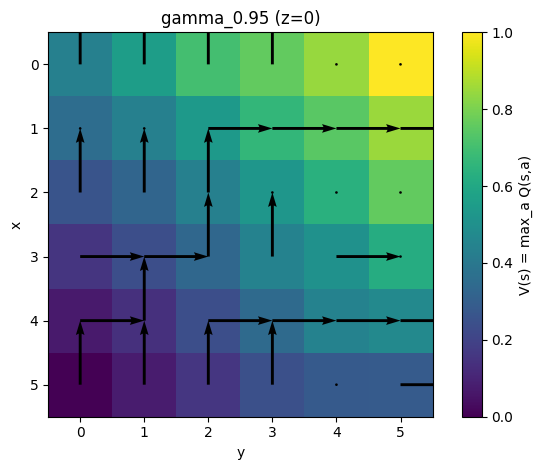

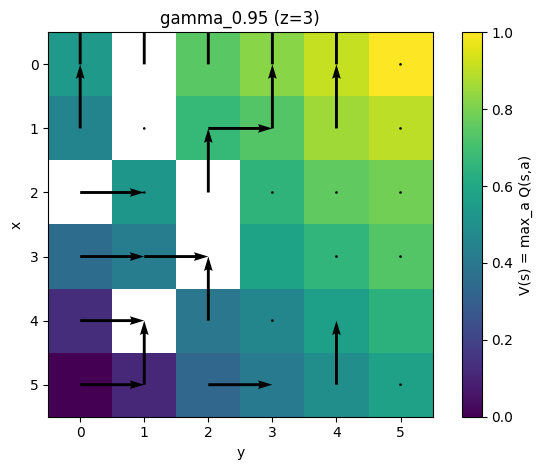

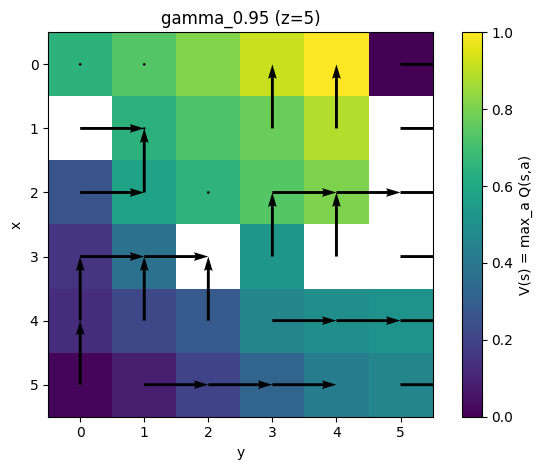

[ep=1] return=-648.0 eps=0.999
[ep=500] return=-3.0 eps=0.606
[ep=1000] return=22.0 eps=0.368
[ep=1500] return=19.0 eps=0.223
[ep=2000] return=32.0 eps=0.135
[ep=2500] return=28.0 eps=0.082
[ep=3000] return=32.0 eps=0.050
[ep=3500] return=33.0 eps=0.050
[ep=4000] return=36.0 eps=0.050
[ep=4500] return=35.0 eps=0.050
[ep=5000] return=34.0 eps=0.050


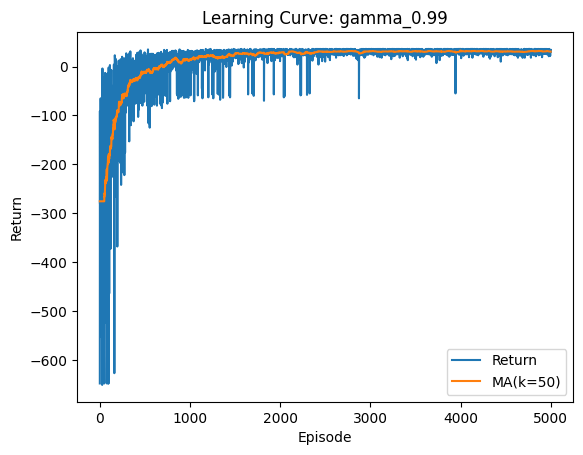

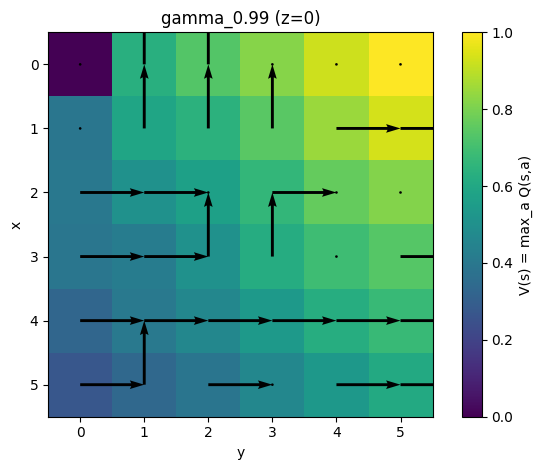

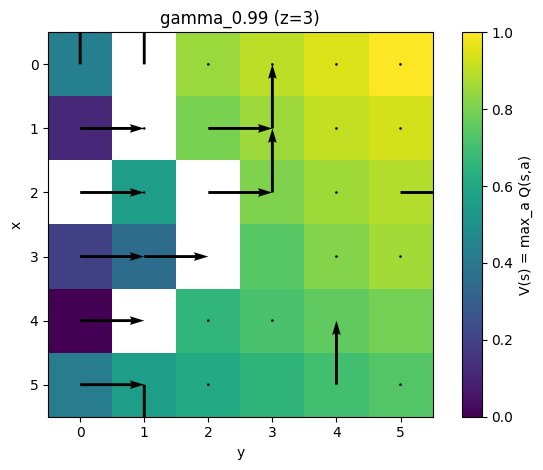

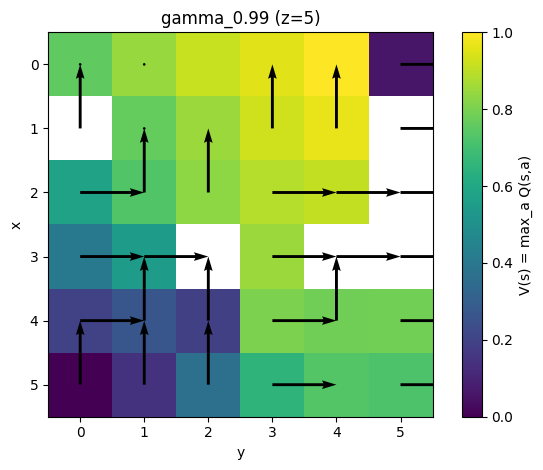

[ep=1] return=-648.0 eps=0.999
[ep=500] return=-33.0 eps=0.606
[ep=1000] return=21.0 eps=0.368
[ep=1500] return=25.0 eps=0.223
[ep=2000] return=27.0 eps=0.135
[ep=2500] return=29.0 eps=0.082
[ep=3000] return=17.0 eps=0.050
[ep=3500] return=28.0 eps=0.050
[ep=4000] return=32.0 eps=0.050
[ep=4500] return=35.0 eps=0.050
[ep=5000] return=33.0 eps=0.050


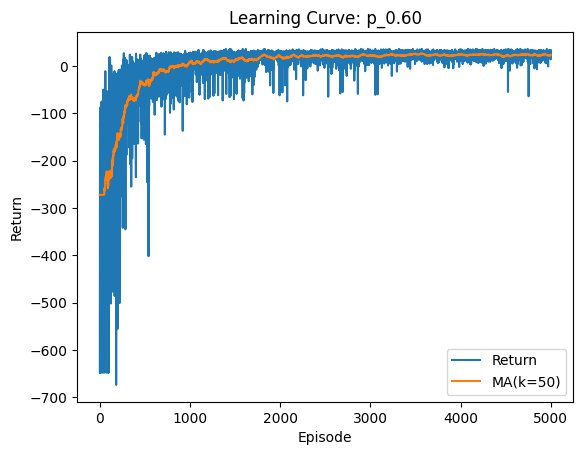

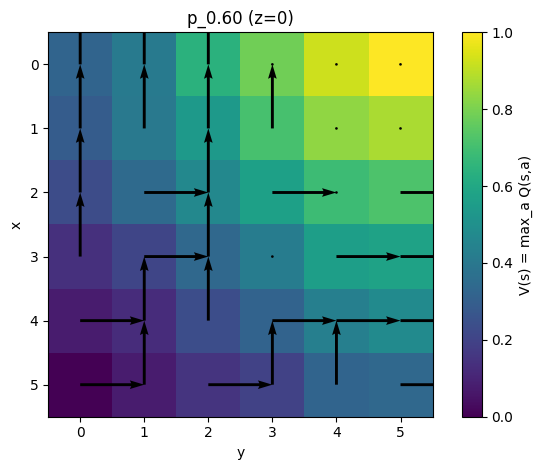

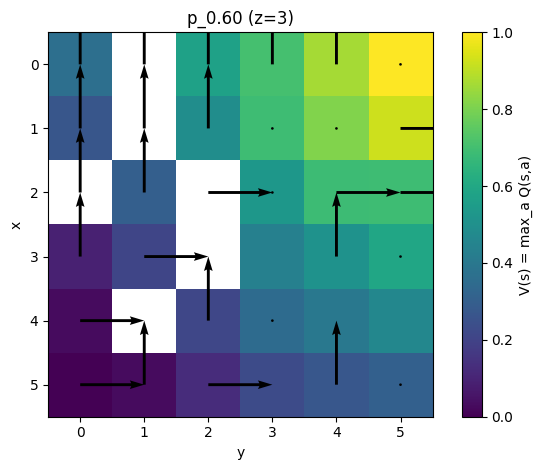

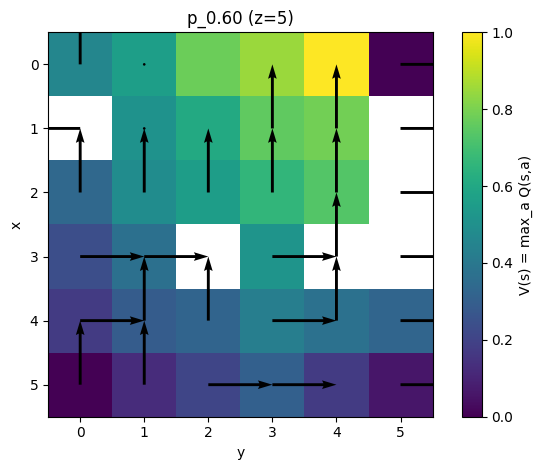

[ep=1] return=-648.0 eps=0.999
[ep=500] return=24.0 eps=0.606
[ep=1000] return=10.0 eps=0.368
[ep=1500] return=28.0 eps=0.223
[ep=2000] return=30.0 eps=0.135
[ep=2500] return=21.0 eps=0.082
[ep=3000] return=30.0 eps=0.050
[ep=3500] return=26.0 eps=0.050
[ep=4000] return=34.0 eps=0.050
[ep=4500] return=36.0 eps=0.050
[ep=5000] return=33.0 eps=0.050


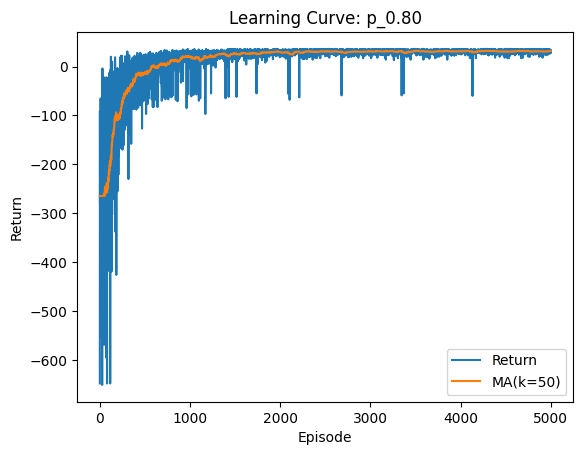

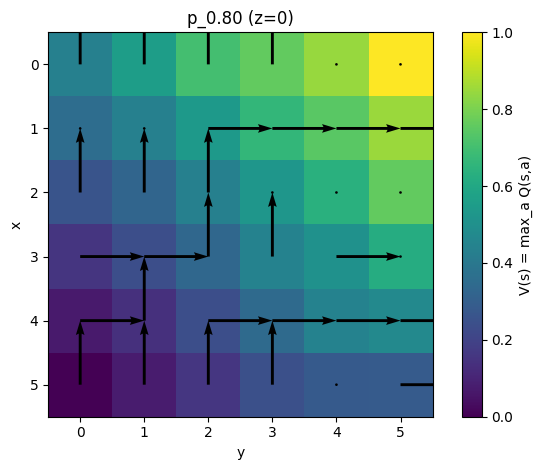

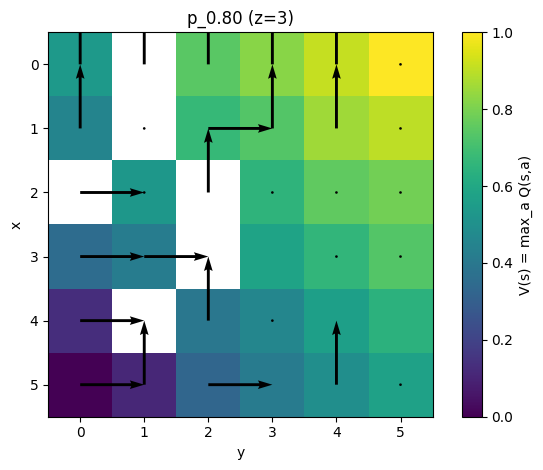

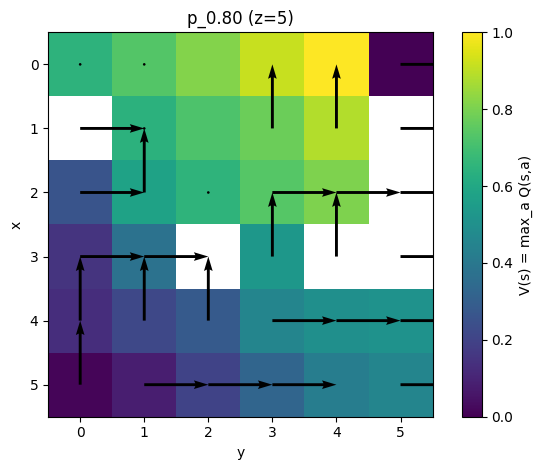

[ep=1] return=-648.0 eps=0.999
[ep=500] return=24.0 eps=0.606
[ep=1000] return=10.0 eps=0.368
[ep=1500] return=28.0 eps=0.223
[ep=2000] return=30.0 eps=0.135
[ep=2500] return=21.0 eps=0.082
[ep=3000] return=30.0 eps=0.050
[ep=3500] return=26.0 eps=0.050
[ep=4000] return=34.0 eps=0.050
[ep=4500] return=36.0 eps=0.050
[ep=5000] return=33.0 eps=0.050


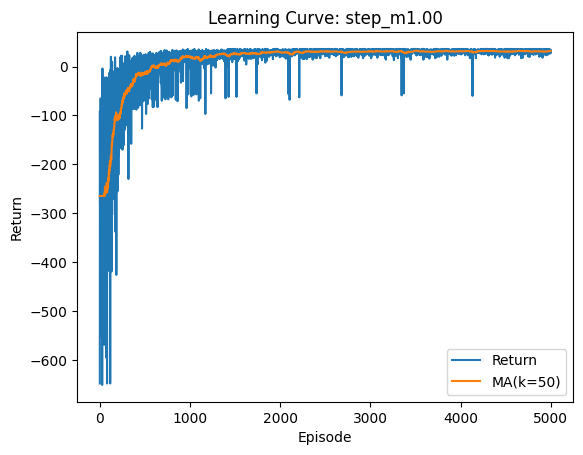

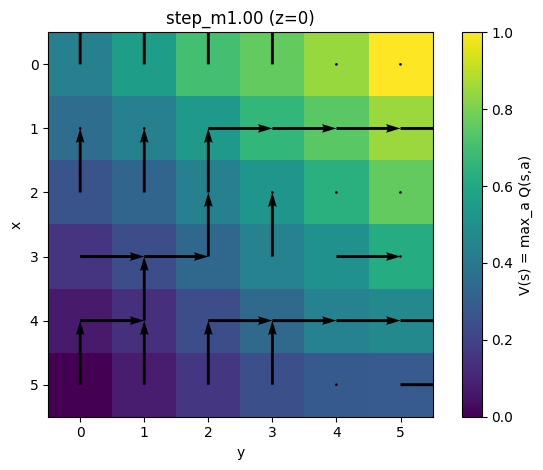

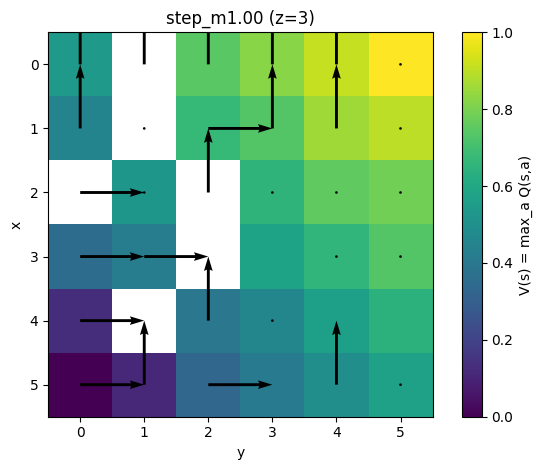

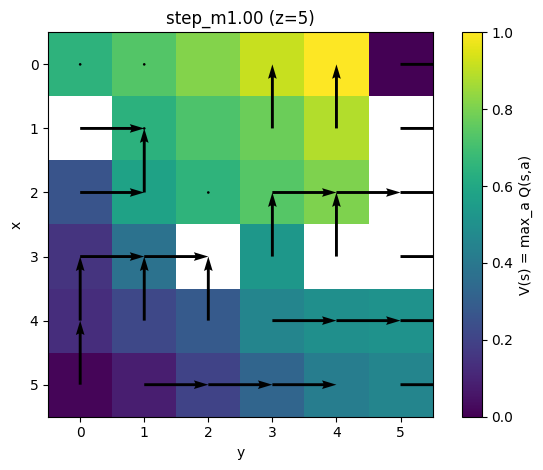

[ep=1] return=-324.0 eps=0.999
[ep=500] return=34.5 eps=0.606
[ep=1000] return=38.0 eps=0.368
[ep=1500] return=36.5 eps=0.223
[ep=2000] return=42.0 eps=0.135
[ep=2500] return=42.0 eps=0.082
[ep=3000] return=40.5 eps=0.050
[ep=3500] return=42.5 eps=0.050
[ep=4000] return=42.0 eps=0.050
[ep=4500] return=42.5 eps=0.050
[ep=5000] return=42.5 eps=0.050


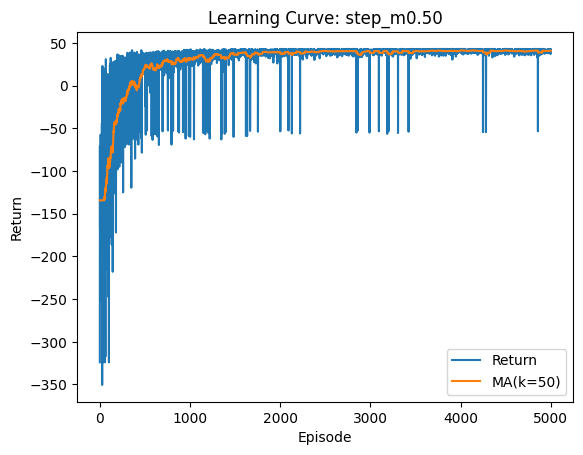

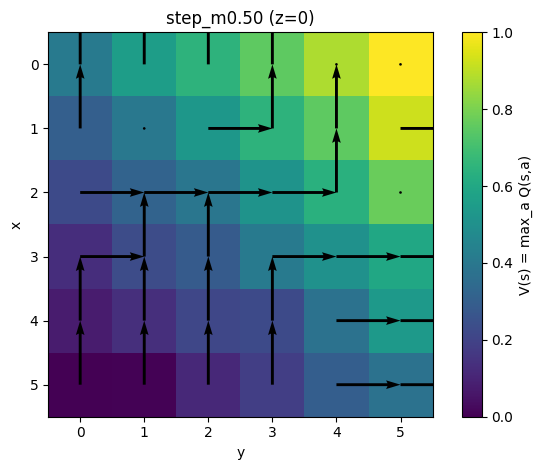

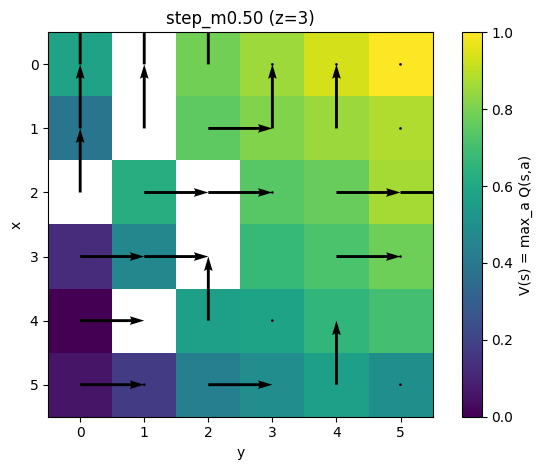

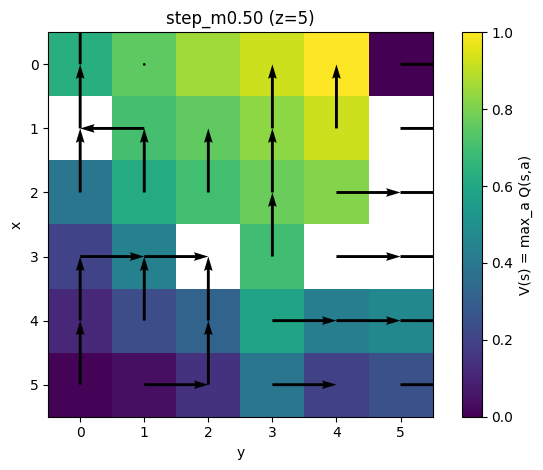

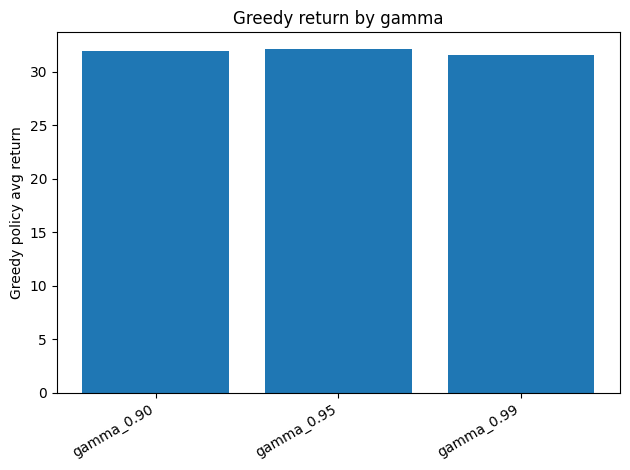

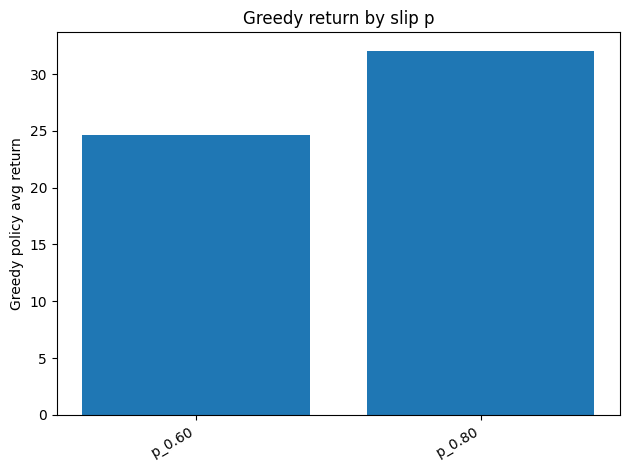

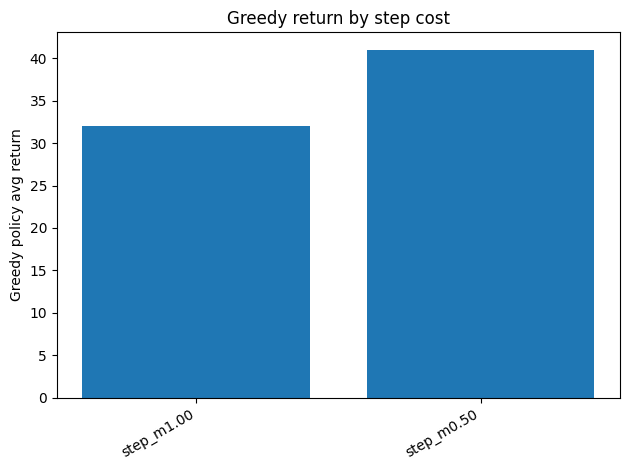

=== sweep_gamma.csv ===
 tag,gamma,p_intended,step_cost,greedy_avg,random_avg,avg_return_last100
gamma_0.90,0.9,0.8,-1.0,31.94,-270.93,30.65
gamma_0.95,0.95,0.8,-1.0,32.07,-270.87,31.29
gamma_0.99,0.99,0.8,-1.0,31.58,-257.41,30.9

=== sweep_p.csv ===
 tag,gamma,p_intended,step_cost,greedy_avg,random_avg,avg_return_last100
p_0.60,0.95,0.6,-1.0,24.62,-236.04,23.41
p_0.80,0.95,0.8,-1.0,32.07,-270.87,31.29

=== sweep_step_cost.csv ===
 tag,gamma,p_intended,step_cost,greedy_avg,random_avg,avg_return_last100
step_m1.00,0.95,0.8,-1.0,32.07,-270.87,31.29
step_m0.50,0.95,0.8,-0.5,41.025,-152.195,40.74



In [ ]:
import csv, io, numpy as np
import matplotlib.pyplot as plt

def run_one_nb(spec, qcfg, episodes=5000, tag="run"):
    # rebuild env/agent fresh per run
    env = Gridworld3D(spec)
    cfg = QConfig(alpha=qcfg.alpha, gamma=qcfg.gamma, episodes=episodes,
                  max_steps_per_ep=qcfg.max_steps_per_ep,
                  eps_schedule=qcfg.eps_schedule, seed=qcfg.seed)
    agent = QLearningAgent(env, cfg)
    rets = agent.train()
    g_avg = eval_greedy(agent, env, episodes=100)
    r_avg = evaluate_random_policy(env, episodes=100)
    # show curve inline
    plt.figure(); plt.plot(rets, label="Return");
    from math import isnan
    # moving avg
    def moving_average(x, k=50):
        if k<=1: return x
        c=np.cumsum(np.insert(x,0,0.0))
        out=(c[k:]-c[:-k])/k
        return np.concatenate([np.full(k-1, out[0]), out])
    plt.plot(moving_average(rets,50), label="MA(k=50)");
    plt.title(f"Learning Curve: {tag}"); plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend(); plt.show()
    # show 3 slices
    for z in [0, spec.D//2, spec.D-1]:
        plot_slice_notebook(env, agent.Q, z, title=f"{tag} (z={z})")
    final_ma = float(np.mean(rets[-100:])) if len(rets)>=100 else float(np.mean(rets))
    return {"tag": tag, "gamma": cfg.gamma, "p_intended": spec.p_intended, "step_cost": spec.step_cost,
            "greedy_avg": g_avg, "random_avg": r_avg, "avg_return_last100": final_ma}

# Base settings (assignment defaults)
base_spec = GridSpec(H=6, W=6, D=6, p_intended=0.8, step_cost=-1.0, gamma=0.95,
                     goal=(5,5,5), pit=(2,2,2), obstacle_ratio=0.12, start=(0,0,0), seed=12345)
base_q = QConfig(alpha=0.2, gamma=base_spec.gamma, episodes=5000,
                 eps_schedule=EpsilonSchedule(start=1.0, end=0.05, decay=0.999), seed=2024)

# Sweep 1: gamma
gamma_vals = [0.90, 0.95, 0.99]
rows_g = []
for g in gamma_vals:
    base_q.gamma = g
    rows_g.append(run_one_nb(base_spec, base_q, episodes=5000, tag=f"gamma_{g:.2f}"))

# Sweep 2: slip probability p
p_vals = [0.60, 0.80]
rows_p = []
for p in p_vals:
    spec = GridSpec(**{**base_spec.__dict__, "p_intended": p})
    base_q.gamma = base_spec.gamma
    rows_p.append(run_one_nb(spec, base_q, episodes=5000, tag=f"p_{p:.2f}"))

# Sweep 3: step cost
step_vals = [-1.0, -0.5]
rows_c = []
for c in step_vals:
    spec = GridSpec(**{**base_spec.__dict__, "step_cost": c})
    rows_c.append(run_one_nb(spec, base_q, episodes=5000, tag=f"step_{c:.2f}".replace("-", "m")))

# Show bar comparisons inline
def bar_inline(rows, title):
    tags=[r["tag"] for r in rows]; vals=[r["greedy_avg"] for r in rows]
    plt.figure(); plt.bar(range(len(vals)), vals);
    plt.xticks(range(len(tags)), tags, rotation=30, ha='right')
    plt.ylabel("Greedy policy avg return"); plt.title(title); plt.tight_layout(); plt.show()

bar_inline(rows_g, "Greedy return by gamma")
bar_inline(rows_p, "Greedy return by slip p")
bar_inline(rows_c, "Greedy return by step cost")

# Optional: export a CSV string you can download from the cell output
def to_csv_str(rows):
    if not rows: return ""
    keys = rows[0].keys()
    buf = io.StringIO(); w = csv.DictWriter(buf, fieldnames=keys); w.writeheader(); w.writerows(rows)
    return buf.getvalue()

print("=== sweep_gamma.csv ===\n", to_csv_str(rows_g))
print("=== sweep_p.csv ===\n",     to_csv_str(rows_p))
print("=== sweep_step_cost.csv ===\n", to_csv_str(rows_c))


[ep=1] return=-648.0 eps=0.999
[ep=500] return=-4.0 eps=0.606
[ep=1000] return=22.0 eps=0.368
[ep=1500] return=12.0 eps=0.223
[ep=2000] return=36.0 eps=0.135
[ep=2500] return=34.0 eps=0.082
[ep=3000] return=23.0 eps=0.050
[ep=3500] return=31.0 eps=0.050
[ep=4000] return=34.0 eps=0.050
[ep=4500] return=35.0 eps=0.050
[ep=5000] return=30.0 eps=0.050


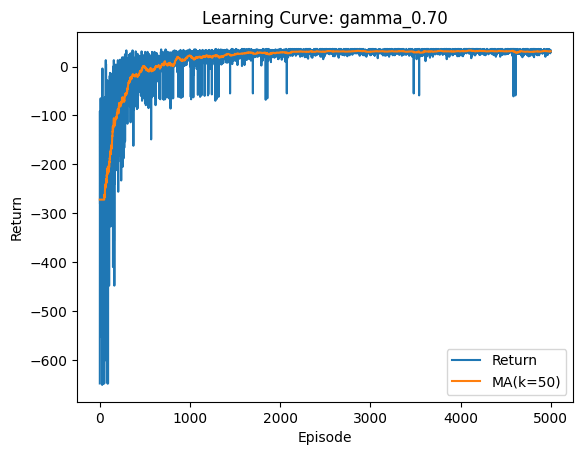

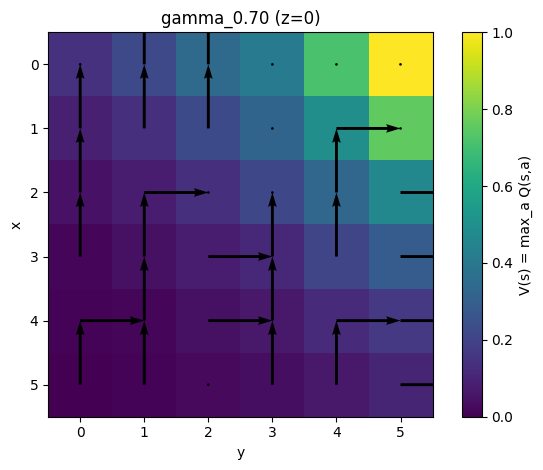

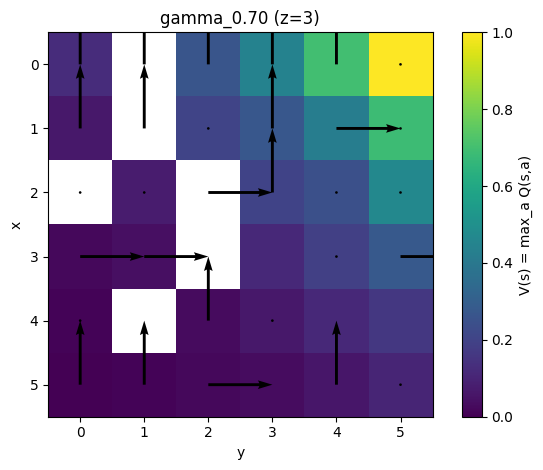

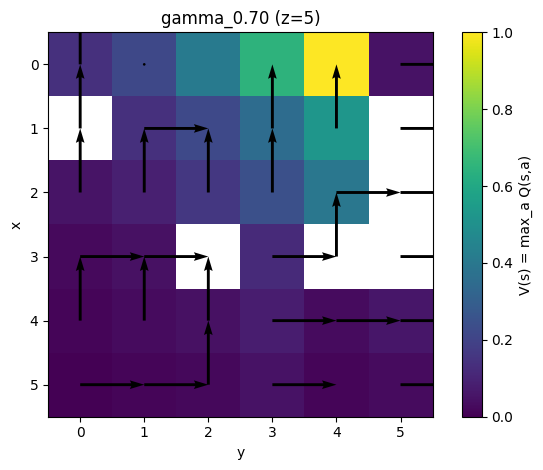

[ep=1] return=-648.0 eps=0.999
[ep=500] return=17.0 eps=0.606
[ep=1000] return=26.0 eps=0.368
[ep=1500] return=29.0 eps=0.223
[ep=2000] return=26.0 eps=0.135
[ep=2500] return=30.0 eps=0.082
[ep=3000] return=30.0 eps=0.050
[ep=3500] return=36.0 eps=0.050
[ep=4000] return=30.0 eps=0.050
[ep=4500] return=25.0 eps=0.050
[ep=5000] return=27.0 eps=0.050


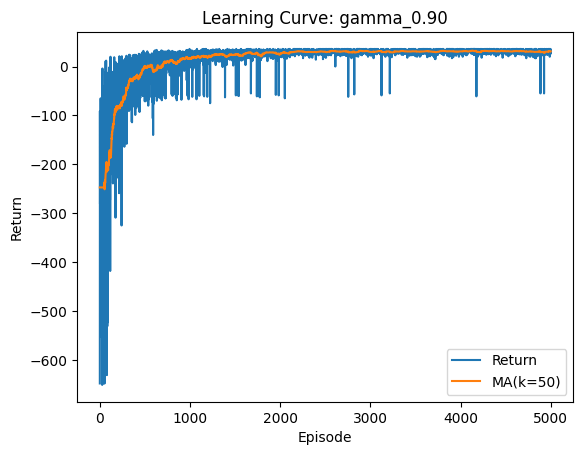

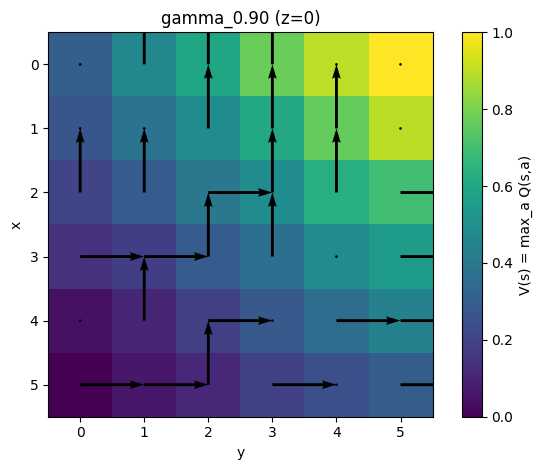

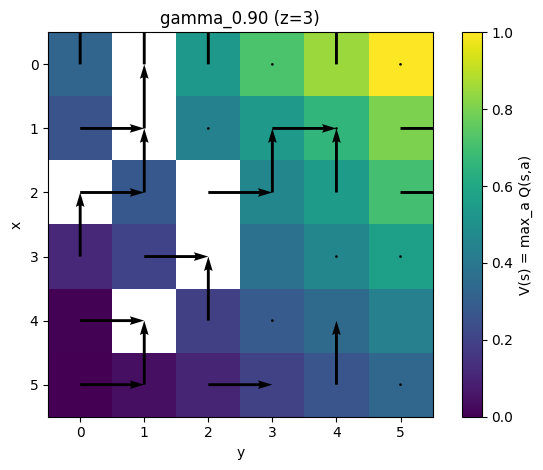

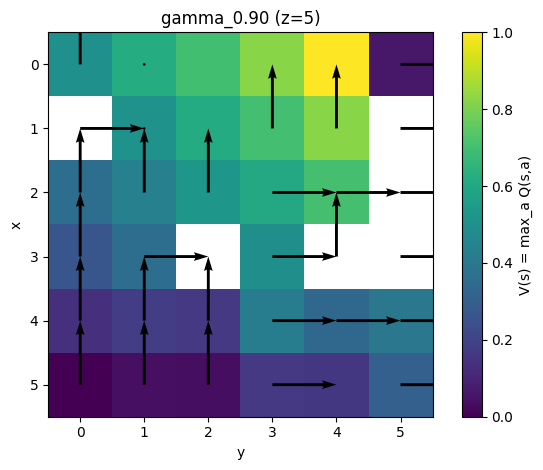

[ep=1] return=-648.0 eps=0.999
[ep=500] return=24.0 eps=0.606
[ep=1000] return=10.0 eps=0.368
[ep=1500] return=28.0 eps=0.223
[ep=2000] return=30.0 eps=0.135
[ep=2500] return=21.0 eps=0.082
[ep=3000] return=30.0 eps=0.050
[ep=3500] return=26.0 eps=0.050
[ep=4000] return=34.0 eps=0.050
[ep=4500] return=36.0 eps=0.050
[ep=5000] return=33.0 eps=0.050


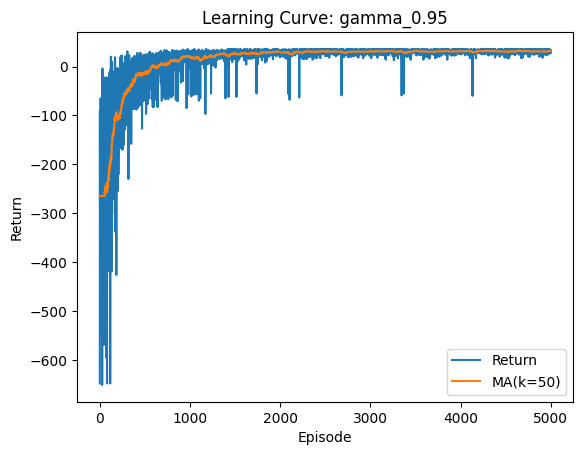

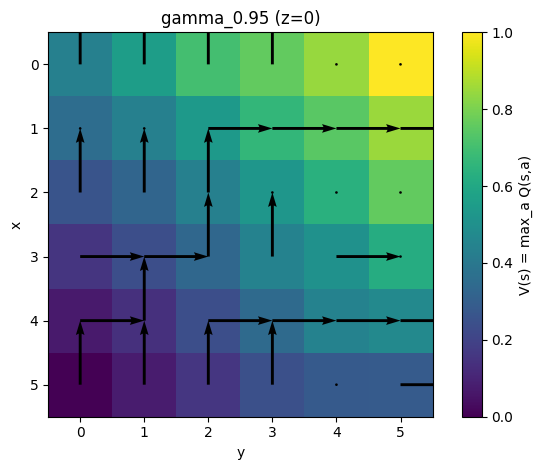

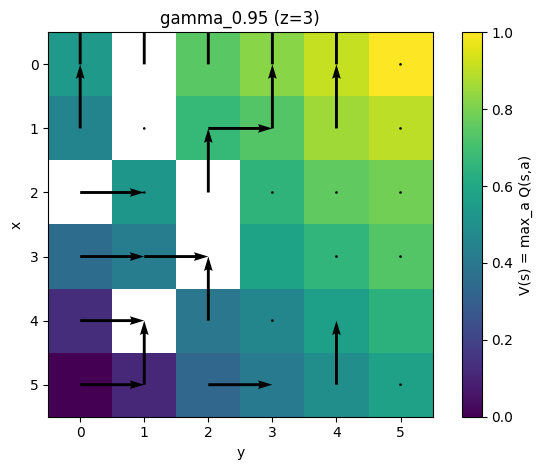

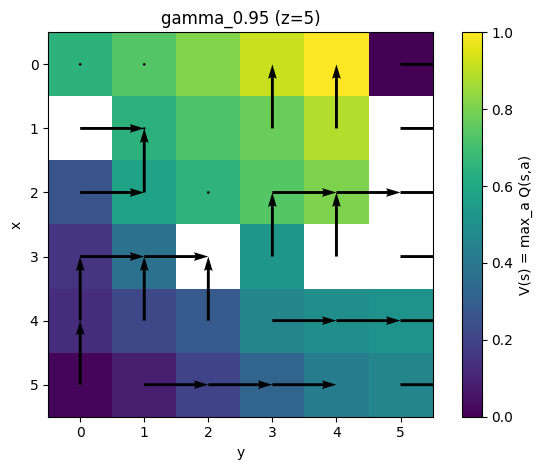

[ep=1] return=-648.0 eps=0.999
[ep=500] return=-3.0 eps=0.606
[ep=1000] return=22.0 eps=0.368
[ep=1500] return=19.0 eps=0.223
[ep=2000] return=32.0 eps=0.135
[ep=2500] return=28.0 eps=0.082
[ep=3000] return=32.0 eps=0.050
[ep=3500] return=33.0 eps=0.050
[ep=4000] return=36.0 eps=0.050
[ep=4500] return=35.0 eps=0.050
[ep=5000] return=34.0 eps=0.050


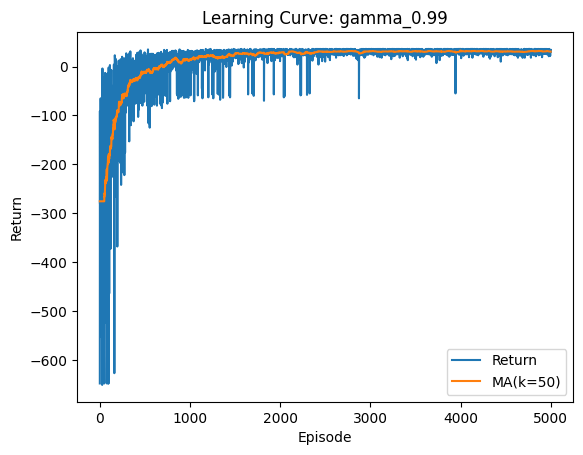

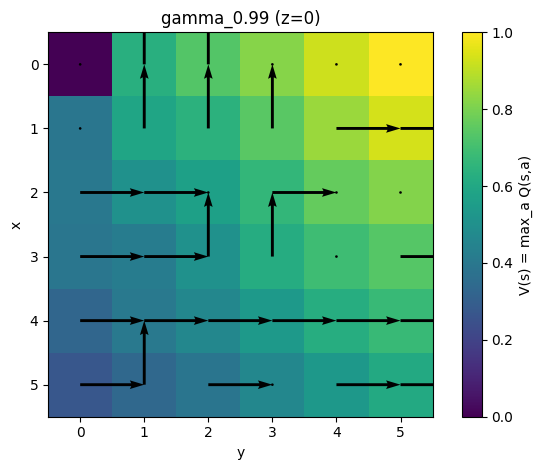

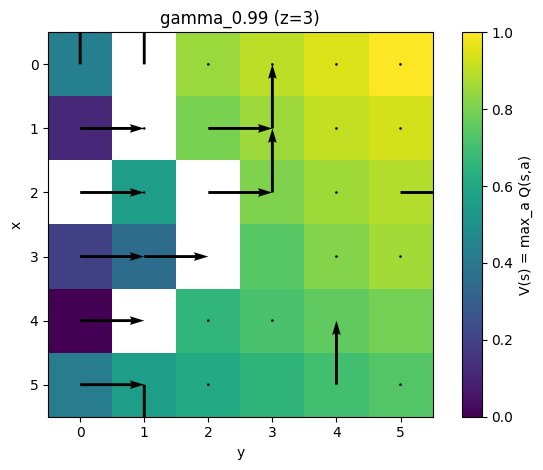

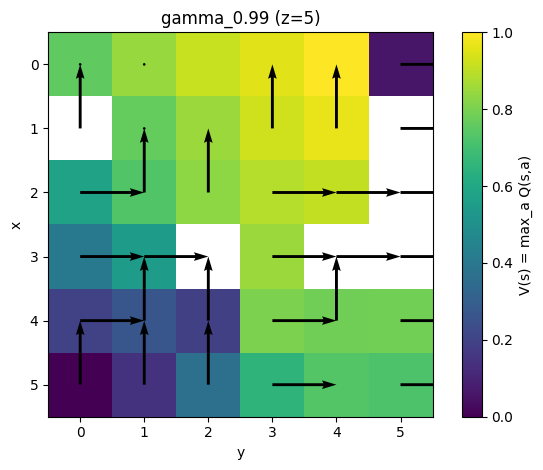

[ep=1] return=-205.0 eps=0.999
[ep=500] return=-76.0 eps=0.606
[ep=1000] return=-118.0 eps=0.368
[ep=1500] return=-26.0 eps=0.223
[ep=2000] return=16.0 eps=0.135
[ep=2500] return=6.0 eps=0.082
[ep=3000] return=12.0 eps=0.050
[ep=3500] return=23.0 eps=0.050
[ep=4000] return=5.0 eps=0.050
[ep=4500] return=3.0 eps=0.050
[ep=5000] return=0.0 eps=0.050


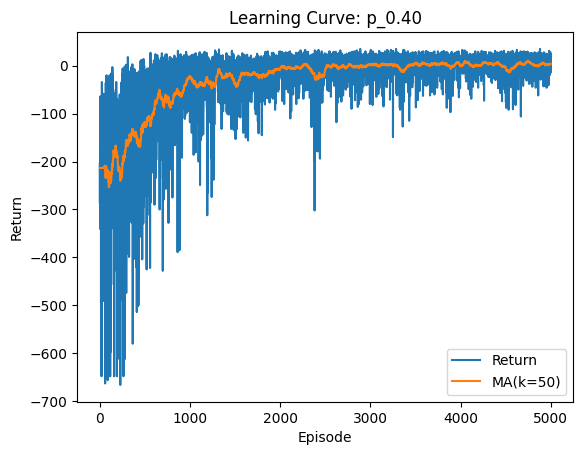

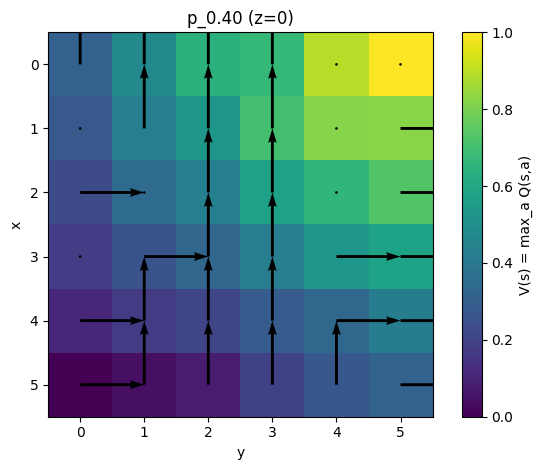

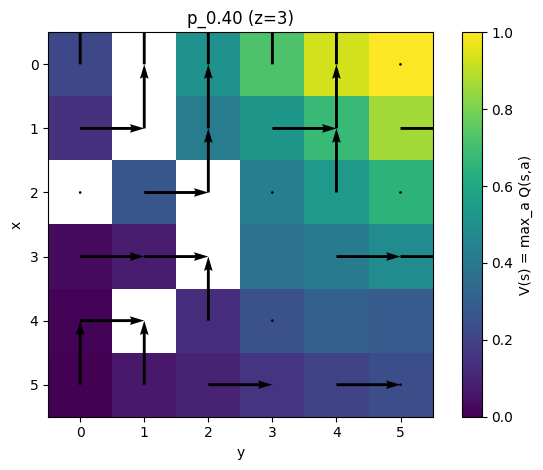

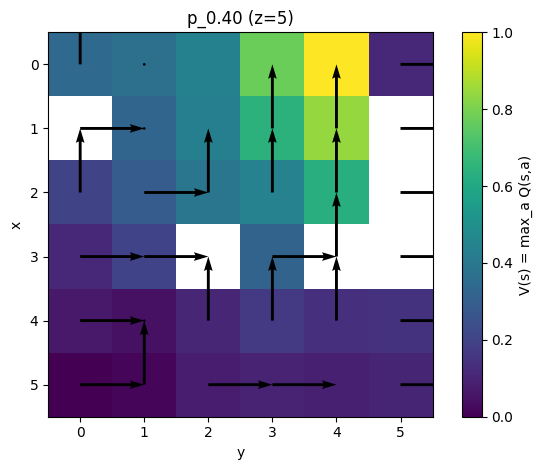

[ep=1] return=-648.0 eps=0.999
[ep=500] return=-33.0 eps=0.606
[ep=1000] return=21.0 eps=0.368
[ep=1500] return=25.0 eps=0.223
[ep=2000] return=27.0 eps=0.135
[ep=2500] return=29.0 eps=0.082
[ep=3000] return=17.0 eps=0.050
[ep=3500] return=28.0 eps=0.050
[ep=4000] return=32.0 eps=0.050
[ep=4500] return=35.0 eps=0.050
[ep=5000] return=33.0 eps=0.050


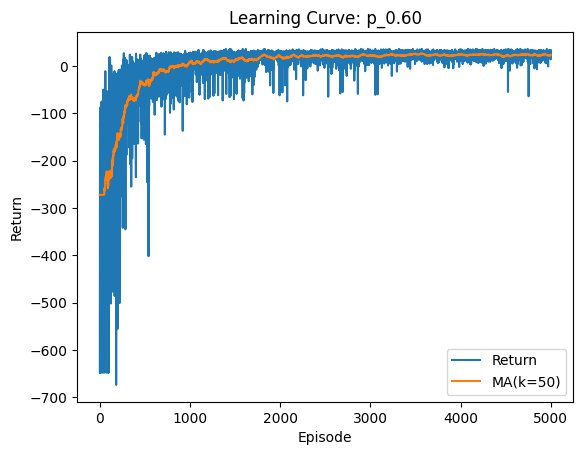

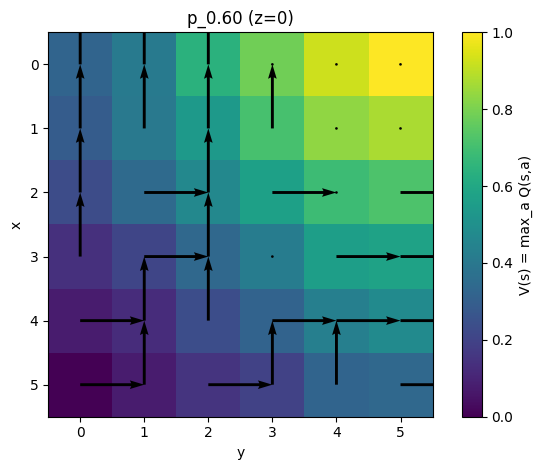

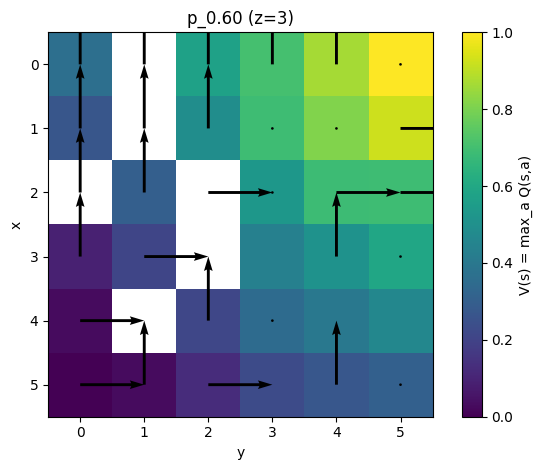

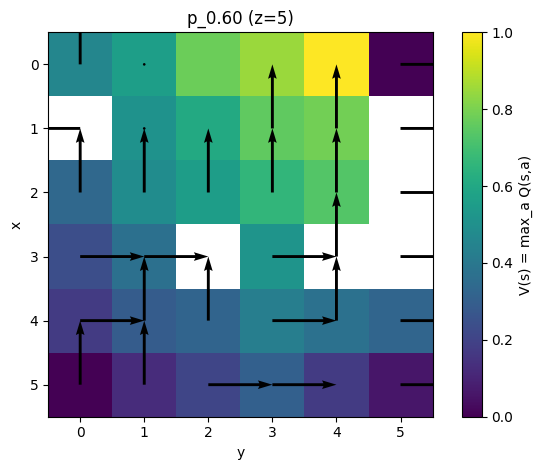

[ep=1] return=-493.0 eps=0.999
[ep=500] return=-3.0 eps=0.606
[ep=1000] return=23.0 eps=0.368
[ep=1500] return=22.0 eps=0.223
[ep=2000] return=32.0 eps=0.135
[ep=2500] return=30.0 eps=0.082
[ep=3000] return=24.0 eps=0.050
[ep=3500] return=27.0 eps=0.050
[ep=4000] return=32.0 eps=0.050
[ep=4500] return=30.0 eps=0.050
[ep=5000] return=26.0 eps=0.050


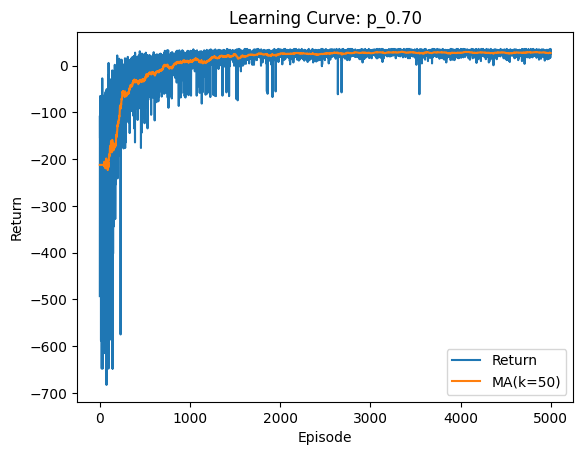

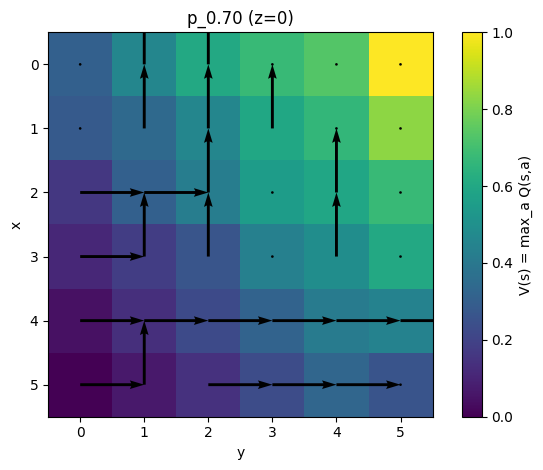

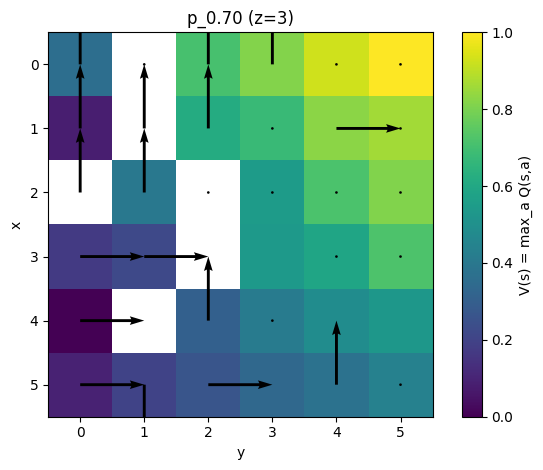

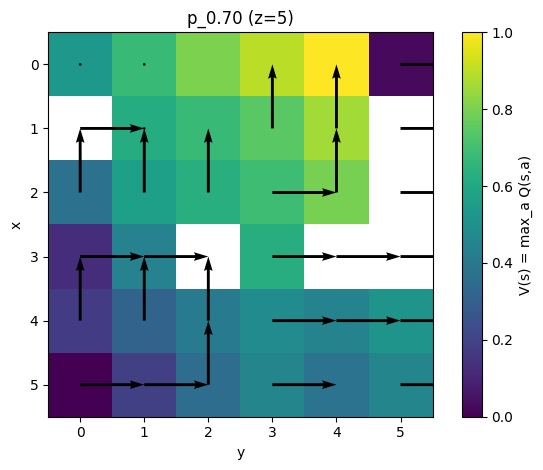

[ep=1] return=-648.0 eps=0.999
[ep=500] return=24.0 eps=0.606
[ep=1000] return=10.0 eps=0.368
[ep=1500] return=28.0 eps=0.223
[ep=2000] return=30.0 eps=0.135
[ep=2500] return=21.0 eps=0.082
[ep=3000] return=30.0 eps=0.050
[ep=3500] return=26.0 eps=0.050
[ep=4000] return=34.0 eps=0.050
[ep=4500] return=36.0 eps=0.050
[ep=5000] return=33.0 eps=0.050


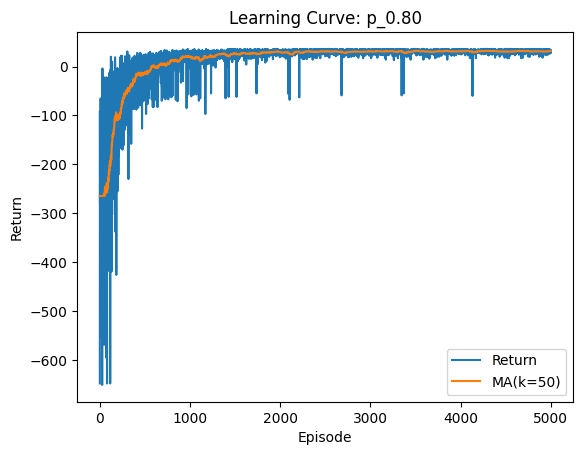

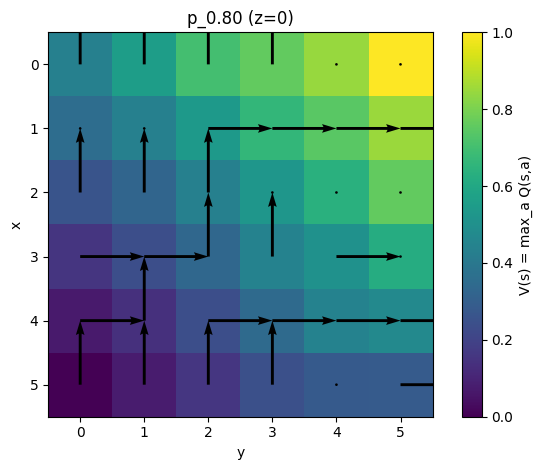

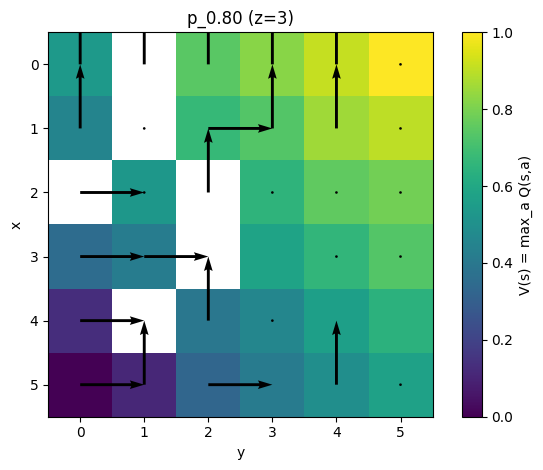

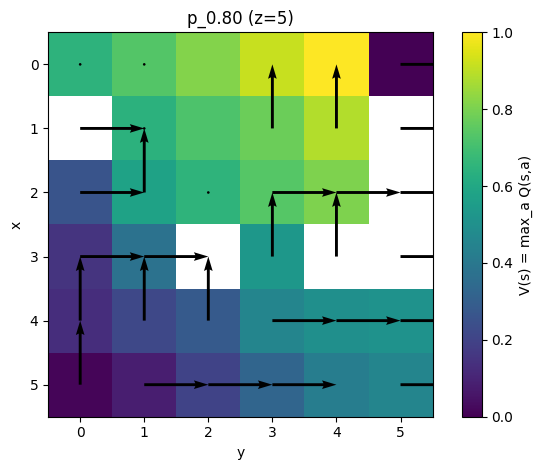

[ep=1] return=-1296.0 eps=0.999
[ep=500] return=-78.0 eps=0.606
[ep=1000] return=-16.0 eps=0.368
[ep=1500] return=14.0 eps=0.223
[ep=2000] return=10.0 eps=0.135
[ep=2500] return=16.0 eps=0.082
[ep=3000] return=14.0 eps=0.050
[ep=3500] return=14.0 eps=0.050
[ep=4000] return=18.0 eps=0.050
[ep=4500] return=10.0 eps=0.050
[ep=5000] return=20.0 eps=0.050


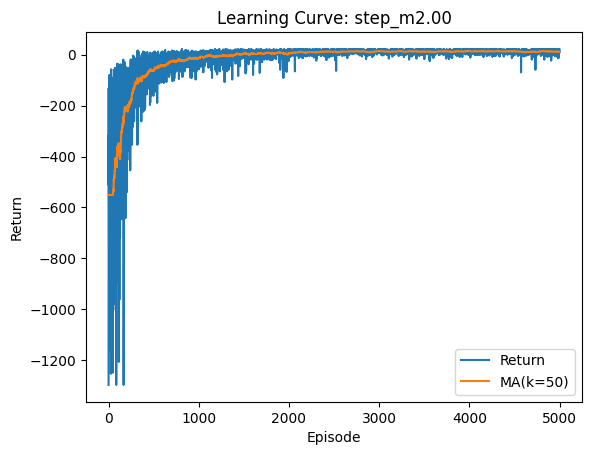

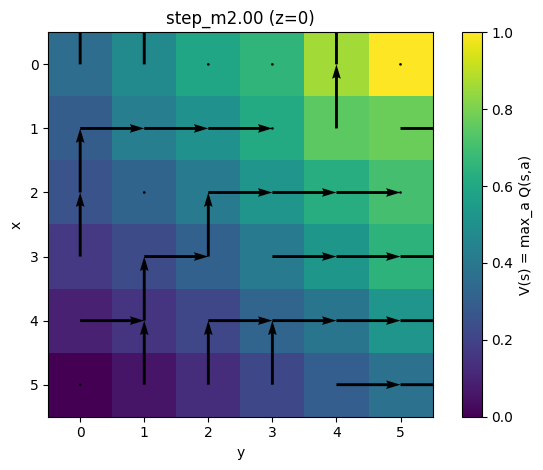

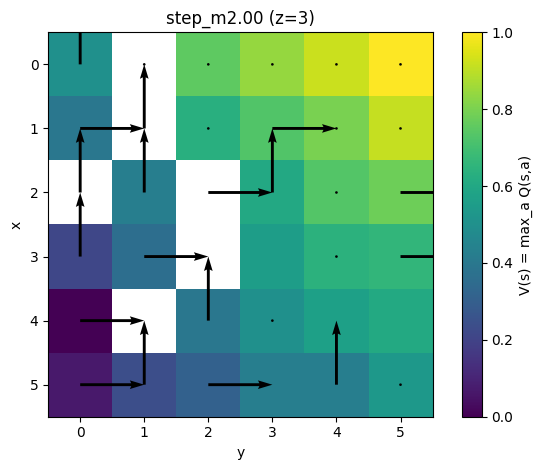

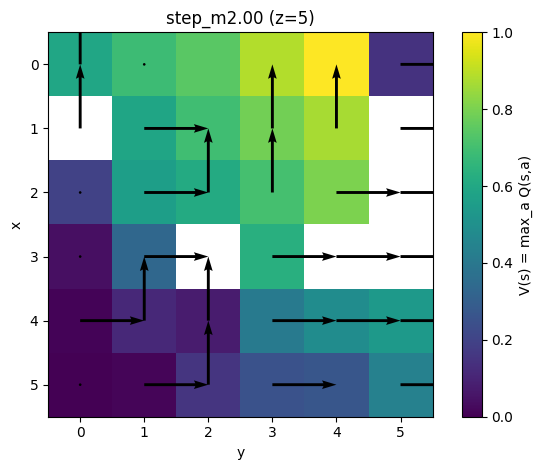

[ep=1] return=-648.0 eps=0.999
[ep=500] return=24.0 eps=0.606
[ep=1000] return=10.0 eps=0.368
[ep=1500] return=28.0 eps=0.223
[ep=2000] return=30.0 eps=0.135
[ep=2500] return=21.0 eps=0.082
[ep=3000] return=30.0 eps=0.050
[ep=3500] return=26.0 eps=0.050
[ep=4000] return=34.0 eps=0.050
[ep=4500] return=36.0 eps=0.050
[ep=5000] return=33.0 eps=0.050


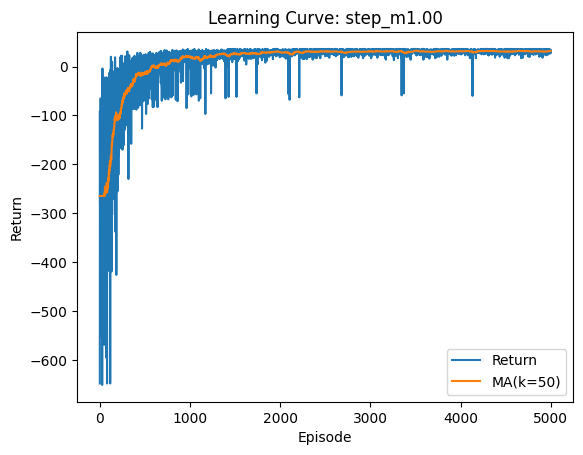

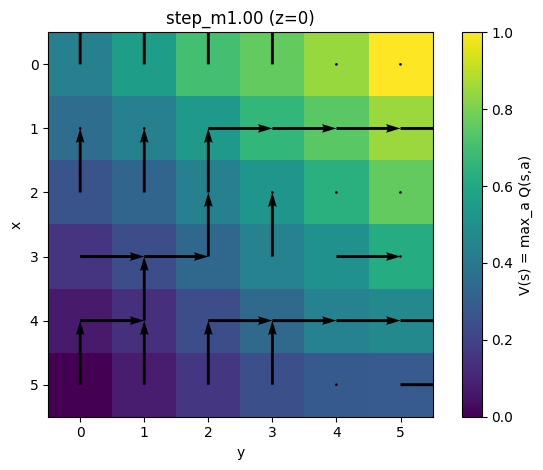

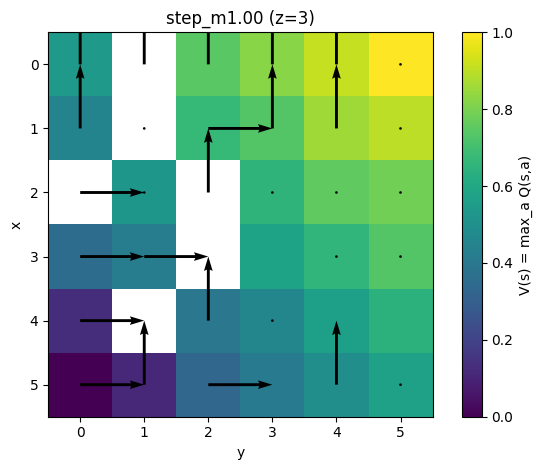

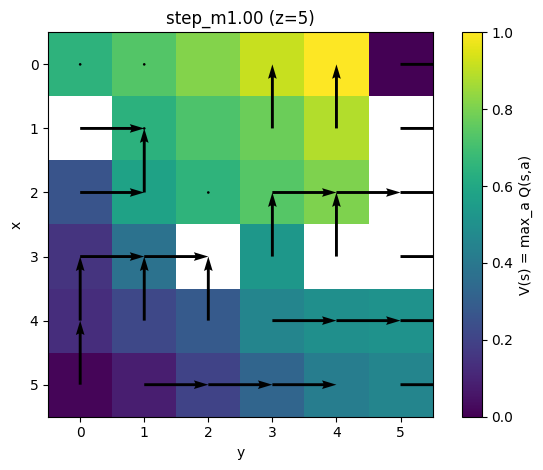

[ep=1] return=-324.0 eps=0.999
[ep=500] return=34.5 eps=0.606
[ep=1000] return=38.0 eps=0.368
[ep=1500] return=36.5 eps=0.223
[ep=2000] return=42.0 eps=0.135
[ep=2500] return=42.0 eps=0.082
[ep=3000] return=40.5 eps=0.050
[ep=3500] return=42.5 eps=0.050
[ep=4000] return=42.0 eps=0.050
[ep=4500] return=42.5 eps=0.050
[ep=5000] return=42.5 eps=0.050


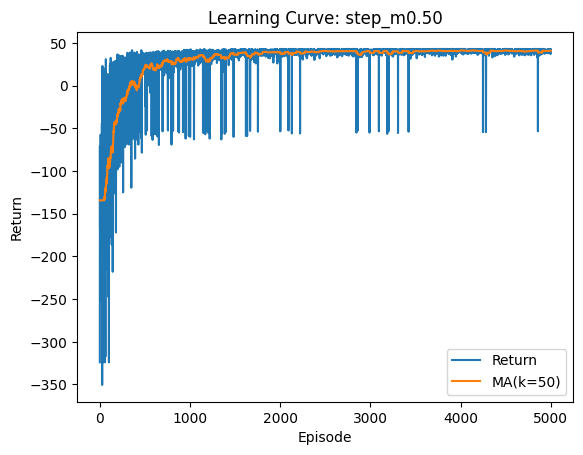

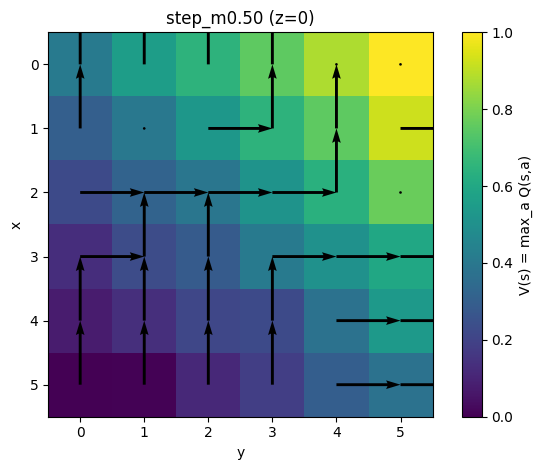

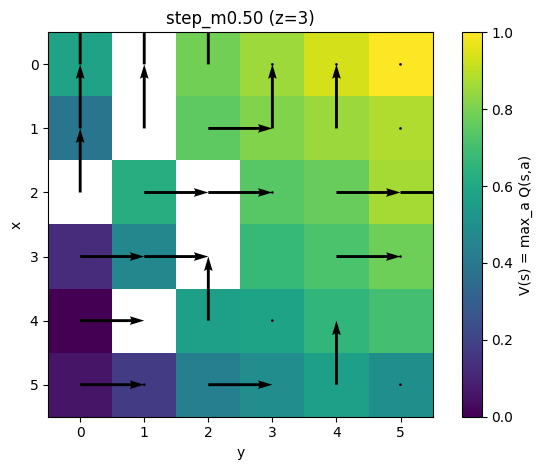

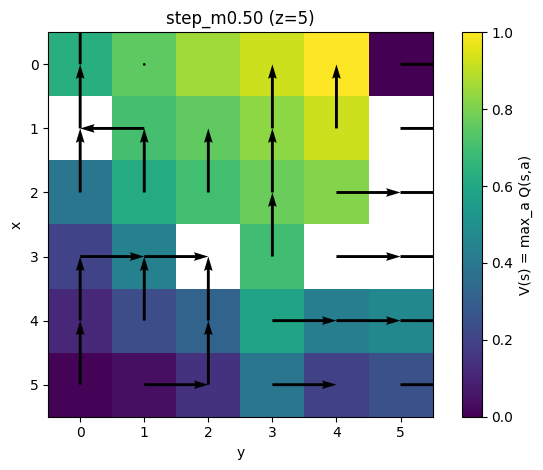

[ep=1] return=-162.0 eps=0.999
[ep=500] return=39.2 eps=0.606
[ep=1000] return=43.5 eps=0.368
[ep=1500] return=45.0 eps=0.223
[ep=2000] return=41.5 eps=0.135
[ep=2500] return=45.5 eps=0.082
[ep=3000] return=45.5 eps=0.050
[ep=3500] return=45.2 eps=0.050
[ep=4000] return=44.8 eps=0.050
[ep=4500] return=46.0 eps=0.050
[ep=5000] return=44.2 eps=0.050


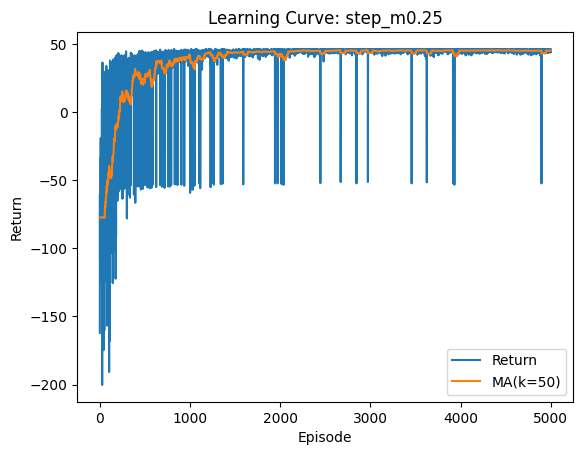

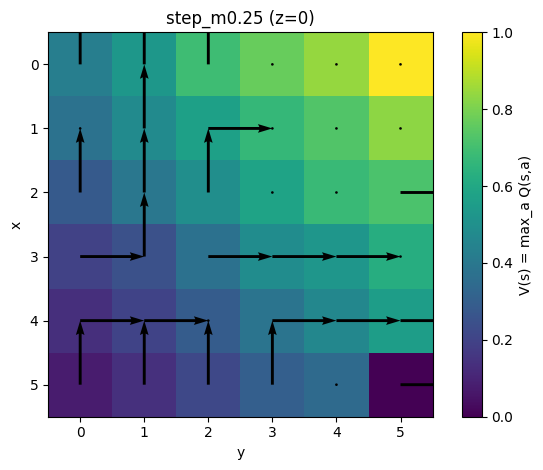

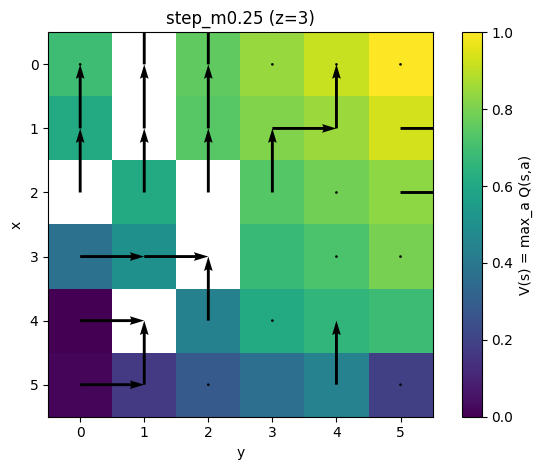

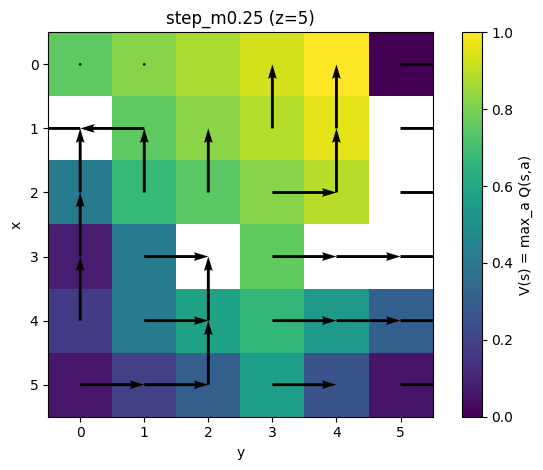

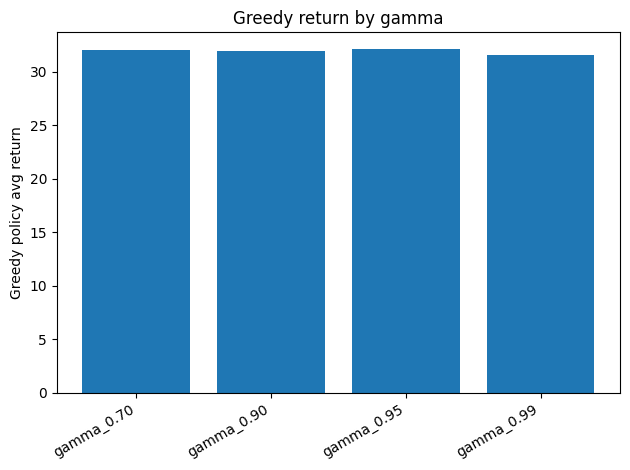

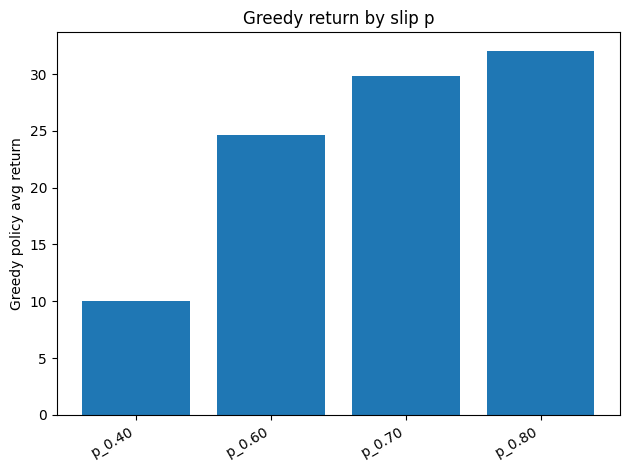

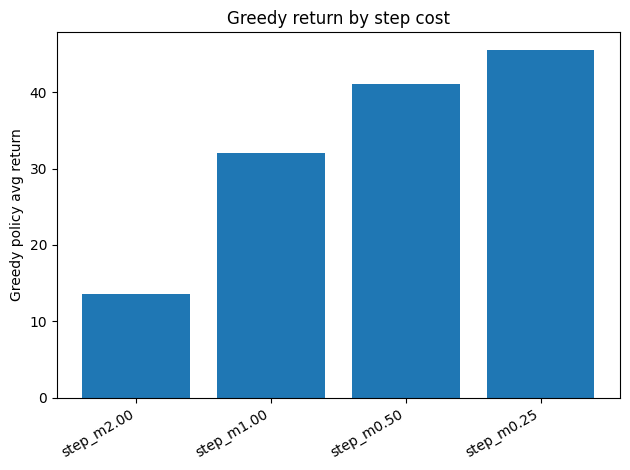

=== sweep_gamma.csv ===
 tag,gamma,p_intended,step_cost,greedy_avg,random_avg,avg_return_last100
gamma_0.70,0.7,0.8,-1.0,32.05,-250.35,31.3
gamma_0.90,0.9,0.8,-1.0,31.94,-270.93,30.65
gamma_0.95,0.95,0.8,-1.0,32.07,-270.87,31.29
gamma_0.99,0.99,0.8,-1.0,31.58,-257.41,30.9

=== sweep_p.csv ===
 tag,gamma,p_intended,step_cost,greedy_avg,random_avg,avg_return_last100
p_0.40,0.95,0.4,-1.0,10.02,-234.39,2.82
p_0.60,0.95,0.6,-1.0,24.62,-236.04,23.41
p_0.70,0.95,0.7,-1.0,29.82,-249.7,27.52
p_0.80,0.95,0.8,-1.0,32.07,-270.87,31.29

=== sweep_step_cost.csv ===
 tag,gamma,p_intended,step_cost,greedy_avg,random_avg,avg_return_last100
step_m2.00,0.95,0.8,-2.0,13.54,-429.6,10.92
step_m1.00,0.95,0.8,-1.0,32.07,-270.87,31.29
step_m0.50,0.95,0.8,-0.5,41.025,-152.195,40.74
step_m0.25,0.95,0.8,-0.25,45.575,-84.8275,45.3175

